In [ ]:
!pip install GPUtil

  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=fe9ca77c3c78d72c3ccbfdb82f5ac435bd8bf4e4621bf7713aae08a6f546ac16
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm
from src.mlmodel import *
import src.utils as utils
from ZSTL_GPU import ZSTL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
net = FuncRecursiveNet([
    FLinearLayer(1, True)
])
shape_record = {0: [(1, 9750)]}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
GPUtil.showUtilization()

cuda:0
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [ ]:
!ls ./drive/'My Drive'/'thesis_data'/'hetrec'/
!cp ./drive/'My Drive'/'thesis_data'/'hetrec'/'detailed_data_0826.pickle' ./
!cp ./drive/'My Drive'/'thesis_data'/'hetrec'/'sampled_task_0826.pickle' ./

detailed_data_0826.pickle	    LastFM_te.mat
detailed_data_colNormalizeA.pickle  LastFM_Xtr.mat
LastFM.mat			    sampled_task_0826.pickle
LastFM_R_te.mat			    sampled_task_colNormalizeA.pickle
LastFM_Str.mat


In [ ]:
path_data = './'
compressed_data = 'sampled_task_0826.pickle'
detailed_data = 'detailed_data_0826.pickle'

with open(path_data+compressed_data, 'rb') as f:
    compressed_dataset = pickle.load(f)

with open(path_data+detailed_data, 'rb') as f:
    detailed_dataset = pickle.load(f)

In [ ]:
train_batch_size = 200
task_id = list(compressed_dataset.keys())
tot_len = len(task_id)
train_size = int(0.8*tot_len)
test_size = tot_len  - train_size
print('train_size ', train_size, 'test_size ', test_size)

support_size = 50
np.random.seed(0)
train_indx_full = list(np.random.choice(task_id, size=train_size, replace=False))
print(train_indx_full)
support_indx = list(np.random.choice(train_indx_full, size=support_size, replace=False))
print(support_indx)

print(len(train_indx_full))
test_indx = [x for x in task_id if x not in train_indx_full]
print(len(test_indx))
print(test_indx)

train_data = utils.Dataset_hetrec([(d, compressed_dataset[d]) for d in train_indx_full], detailed_dataset)
preset_x =  train_data.x
print('preset x ',preset_x.shape)

support_indx = list(np.random.choice(train_indx_full, size=support_size, replace=False))
train_indx = [x for x in train_indx_full if x not in support_indx]
print(len(support_indx), len(train_indx))

support_data = utils.Dataset_hetrec([(d, compressed_dataset[d]) for d in support_indx], detailed_dataset, preset_x =preset_x,train_task=True)
train_data = utils.Dataset_hetrec([(d, compressed_dataset[d]) for d in train_indx], detailed_dataset,preset_x =preset_x)
test_data = utils.Dataset_hetrec([(d, compressed_dataset[d]) for d in test_indx], detailed_dataset, preset_x = preset_x)

support_loader = DataLoader(support_data, batch_size=support_size, shuffle=False)
train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_size, shuffle=True)

train_a, train_w, train_x, train_y = next(iter(train_loader))
train_a, train_w, train_x, train_y = train_a.float(), train_w.float(), train_x.float(), train_y.float()
print(train_a.shape, train_w.shape, train_x.shape, train_y.shape)
#print(train_a)

test_a, test_w, test_x, test_y = next(iter(test_loader))
test_a, test_w, test_x, test_y = test_a.float(), test_w.float(), test_x.float(), test_y.float()
print(test_a.shape, test_w.shape, test_x.shape, test_y.shape)

train_size  1513 test_size  379
[310, 348, 1661, 1543, 1323, 1060, 806, 948, 471, 2018, 81, 456, 1271, 1393, 30, 1894, 625, 154, 123, 141, 1599, 961, 1999, 387, 1420, 642, 2007, 484, 1826, 1944, 212, 1798, 21, 537, 1782, 1318, 129, 89, 1156, 2080, 1355, 1150, 1838, 696, 80, 56, 244, 185, 1552, 1687, 633, 1377, 778, 577, 1044, 1354, 1722, 8, 458, 1481, 20, 1451, 344, 1484, 1640, 574, 1904, 612, 112, 84, 856, 1566, 376, 1368, 1881, 1039, 1840, 607, 686, 606, 50, 567, 622, 1470, 1611, 33, 940, 1231, 1506, 862, 1493, 598, 726, 663, 491, 1736, 2013, 296, 420, 1949, 1327, 281, 1292, 912, 237, 1140, 229, 1413, 1959, 2020, 234, 1925, 1180, 1718, 1695, 1545, 828, 1924, 1113, 171, 1691, 763, 913, 1865, 1623, 2051, 163, 623, 271, 508, 802, 1617, 1247, 2097, 1345, 1994, 2042, 627, 526, 1134, 787, 250, 489, 1390, 1819, 584, 548, 2024, 2091, 689, 832, 1477, 1522, 1149, 1794, 477, 1930, 37, 298, 1356, 769, 1622, 823, 198, 1233, 1505, 728, 2079, 887, 1310, 192, 2095, 1151, 875, 657, 355, 16, 1388, 110

In [ ]:
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
dm = support_a.size()[0]
print(dm)
d  = support_w.size()[0]
print(d)
print(support_a.shape, support_w.shape, support_x.shape, support_y.shape)


param_dict = {}
param_dict['rho'] = 1e-5
param_dict['mu'] = 0.01
param_dict['loss'] = 'mAP'
param_dict['outer lr'] = 1e-3
param_dict['align lr'] = 1e-3
param_dict['dm'] = dm
param_dict['d'] = d
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Softmax'
print(param_dict)

1892
9750
torch.Size([1892, 50]) torch.Size([9750, 50]) torch.Size([50, 100, 9750]) torch.Size([50, 100, 1])
{'rho': 1e-05, 'mu': 0.01, 'loss': 'mAP', 'outer lr': 0.001, 'align lr': 0.001, 'dm': 1892, 'd': 9750, 'model_shape': {0: [(1, 9750)]}, 'atten_activation': 'Softmax'}


softmax selected
test  torch.Size([1892, 379]) torch.Size([379]) torch.Size([379, 100, 9750]) torch.Size([379, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7048284960422166; align loss 8.76001262664795
1/800 o_loss 0.6516354708746076; m train metric 0.7164500000000001; m test metric 0.7165171503957788; align loss  0.01752471923828125
200/800 o_loss 0.4276839715987444; m train metric 0.8300999999999995; m test metric 0.7936675461741425; align loss  0.012856483459472656
400/800 o_loss 0.37496400363743304; m train metric 0.8502999999999998; m test metric 0.795118733509235; align loss  0.008948087692260742
600/800 o_loss 0.3566050345636904; m train metric 0.8540499999999989; m test metric 0.7948548812664902; align loss  0.005914449691772461
800/800 o_loss 0.3261528177931905; m train metric 0.8678999999999997; m test metric 0.7952770448548804; align loss  0.003670930862426758
lr  0.001


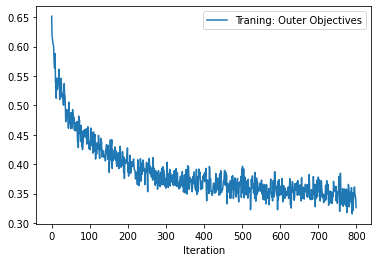

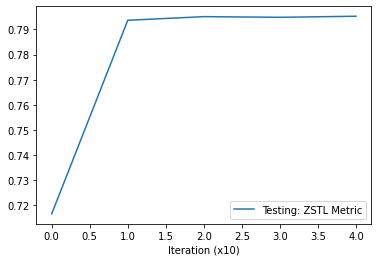

Time: 1102.956619511
| ID | GPU | MEM |
------------------
|  0 |  0% |  6% |


In [ ]:

start = timeit.default_timer()
ZSTL_model = ZSTL(support_w, support_a, net, param_dict, device)
ZSTL_model.train(train_loader, test_loader, max_iter=800)
stop = timeit.default_timer()
print('Time:', stop - start)
GPUtil.showUtilization()



In [ ]:
test_data_full = utils.Dataset_hetrec([(d, compressed_dataset[d]) for d in test_indx], detailed_dataset, preset_x =preset_x, phase='mAP')
test_data_full_loader = DataLoader(test_data_full, batch_size=test_size, shuffle=True)

test_batch = next(iter(test_data_full_loader))
test_a, test_w, test_y = test_batch[0].float(), test_batch[1].float(), \
    test_batch[2].float()

test_x = utils.toTensor(preset_x)
test_a = test_a.squeeze().t()
test_w = test_w.squeeze().t()
print(test_a.shape, test_w.shape, test_y.shape, test_x.shape)

learner  LR
not gen w
torch.Size([1892, 379]) torch.Size([379]) torch.Size([379, 17632, 1]) torch.Size([17632, 9750])


In [ ]:

pred_precision = utils.ZSTL_AvgPrecision(test_a, test_x, test_y, ZSTL_model)
# del ZSTL_model
# torch.cuda.empty_cache()
GPUtil.showUtilization()

mAP at 100  tensor(0.3266, dtype=torch.float64) num task  tensor(379., dtype=torch.float64) precision at k 0.14435356200527713 recall at k 0.2916816286447809
| ID | GPU | MEM |
------------------
|  0 |  1% | 10% |


292
1171
learner  LR
not gen w
learner  LR
not gen w
learner  LR
not gen w
100
torch.Size([1892, 292])
softmax selected
num of hp  25
rho for w_kb 0.1; mu for a_kb 0.1;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835616; align loss 0.8760124444961548
1/600 o_loss 0.6729040725529194; m train metric 0.7377999999999997; m test metric 0.7187328767123284; align loss  0.001763463020324707
200/600 o_loss 0.44841741293668747; m train metric 0.8268; m test metric 0.788904109589041; align loss  0.0012884140014648438
400/600 o_loss 0.44497454032301903; m train metric 0.8205000000000005; m test metric 0.7932534246575342; align loss  0.000895380973815918
600/600 o_loss 0.3928236798942089; m train metric 0.8491000000000001; m test metric 0.7941438356164382; align loss  0.0005915462970733643
lr  0.001


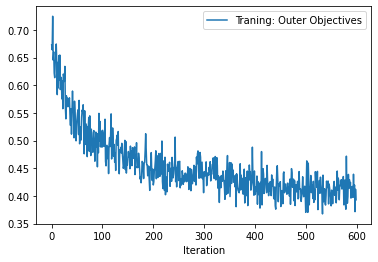

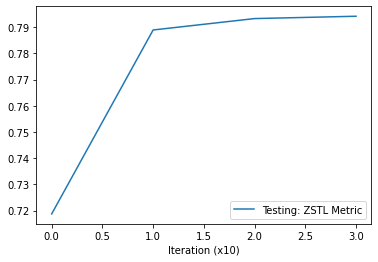

mAP at 100  tensor(0.3341, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.1468150684931507
mean metric 0.3340685830180762
New best acc 0.3340685830180762
rho for w_kb 0.1; mu for a_kb 0.01;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835614; align loss 0.8760124444961548
1/600 o_loss 0.6851255692541599; m train metric 0.7172000000000002; m test metric 0.7179109589041092; align loss  0.001763463020324707
200/600 o_loss 0.4564091834425926; m train metric 0.8127999999999999; m test metric 0.7885616438356158; align loss  0.001288294792175293
400/600 o_loss 0.41284945614635943; m train metric 0.8454000000000004; m test metric 0.7931849315068489; align loss  0.0008954405784606934
600/600 o_loss 0.39867623135447505; m train metric 0.8404; m test metric 0.7947602739726028; align loss  0.0005915313959121704
lr  0.001


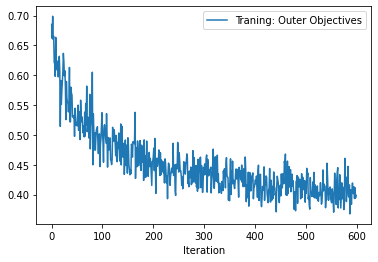

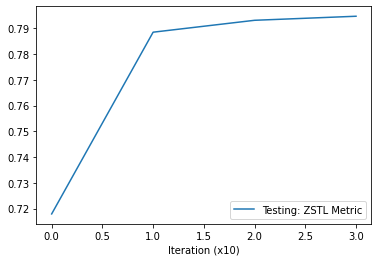

mAP at 100  tensor(0.3366, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.14678082191780825
mean metric 0.33662387950007716
New best acc 0.33662387950007716
rho for w_kb 0.1; mu for a_kb 0.001;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835617; align loss 0.8760124444961548
1/600 o_loss 0.6997649845480919; m train metric 0.7189; m test metric 0.7177054794520549; align loss  0.0017634034156799316
200/600 o_loss 0.4504748634248972; m train metric 0.8242; m test metric 0.7887671232876707; align loss  0.0012884140014648438
400/600 o_loss 0.4054229651391506; m train metric 0.8320999999999998; m test metric 0.7928082191780824; align loss  0.0008953511714935303
600/600 o_loss 0.3996143159270287; m train metric 0.8572999999999997; m test metric 0.7931849315068492; align loss  0.0005915462970733643
lr  0.001


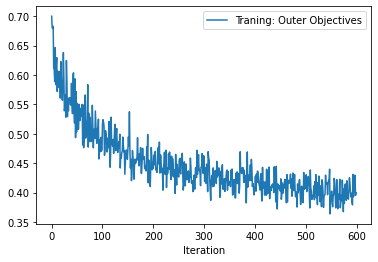

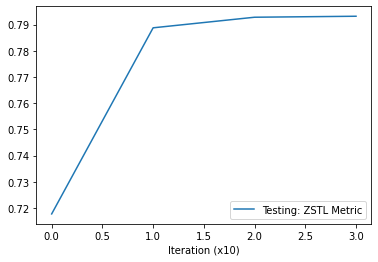

mAP at 100  tensor(0.3395, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.14719178082191772
mean metric 0.33947738292233004
New best acc 0.33947738292233004
rho for w_kb 0.1; mu for a_kb 0.0001;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835619; align loss 0.8760124444961548
1/600 o_loss 0.7068521870672703; m train metric 0.7225; m test metric 0.7183219178082193; align loss  0.0017634034156799316
200/600 o_loss 0.42019734606146814; m train metric 0.8481999999999998; m test metric 0.7892808219178082; align loss  0.0012883543968200684
400/600 o_loss 0.4142407464236021; m train metric 0.8431000000000001; m test metric 0.7922260273972603; align loss  0.0008954107761383057
600/600 o_loss 0.4005929259210825; m train metric 0.8475999999999998; m test metric 0.7930821917808218; align loss  0.0005915462970733643
lr  0.001


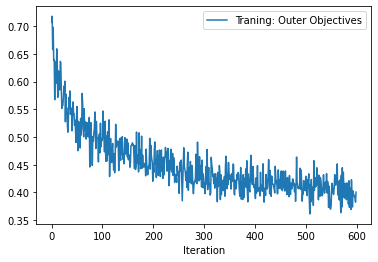

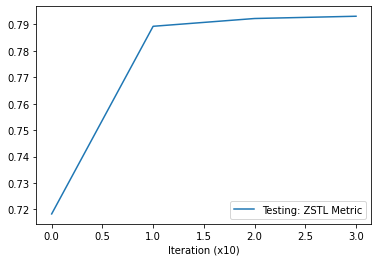

mAP at 100  tensor(0.3355, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.14647260273972607
mean metric 0.3354910641742165
rho for w_kb 0.1; mu for a_kb 1e-05;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835621; align loss 0.8760124444961548
1/600 o_loss 0.6214507003128529; m train metric 0.7600999999999999; m test metric 0.7185958904109593; align loss  0.0017635226249694824
200/600 o_loss 0.47535976715385914; m train metric 0.7988999999999998; m test metric 0.7896917808219176; align loss  0.0012882351875305176
400/600 o_loss 0.42229025050997737; m train metric 0.8310999999999998; m test metric 0.7939726027397264; align loss  0.000895380973815918
600/600 o_loss 0.4080637948215008; m train metric 0.846; m test metric 0.7943835616438356; align loss  0.0005915164947509766
lr  0.001


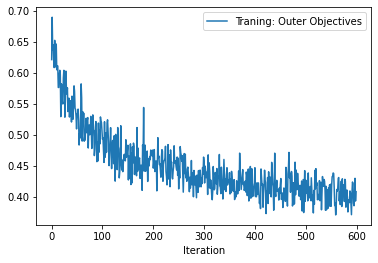

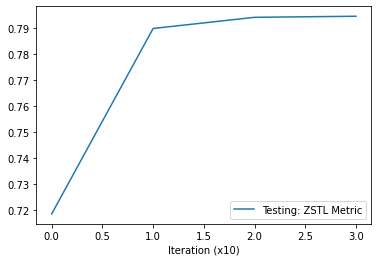

mAP at 100  tensor(0.3348, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.14609589041095894
mean metric 0.3347545918030612
rho for w_kb 0.01; mu for a_kb 0.1;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835615; align loss 0.8760124444961548
1/600 o_loss 0.7161393401026726; m train metric 0.7225999999999998; m test metric 0.7188013698630138; align loss  0.0017635226249694824
200/600 o_loss 0.4905359598249197; m train metric 0.8092; m test metric 0.7896575342465744; align loss  0.0012882351875305176
400/600 o_loss 0.4120624524354935; m train metric 0.8428000000000001; m test metric 0.7930821917808216; align loss  0.0008954405784606934
600/600 o_loss 0.4395943392813206; m train metric 0.8306000000000003; m test metric 0.7944178082191784; align loss  0.0005915611982345581
lr  0.001


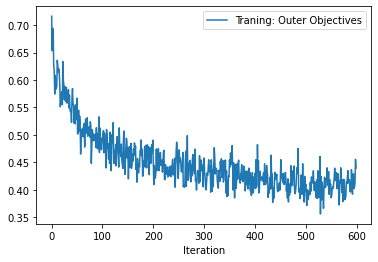

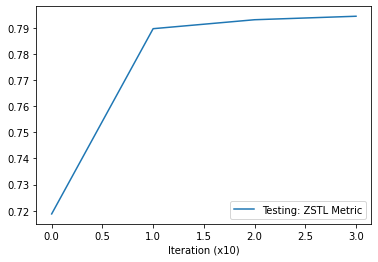

mAP at 100  tensor(0.3376, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.1461986301369863
mean metric 0.3376041510767221
rho for w_kb 0.01; mu for a_kb 0.01;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835614; align loss 0.8760124444961548
1/600 o_loss 0.6801938571035863; m train metric 0.7389999999999999; m test metric 0.718253424657534; align loss  0.0017635226249694824
200/600 o_loss 0.4485464297235012; m train metric 0.8260000000000004; m test metric 0.7888013698630131; align loss  0.001288294792175293
400/600 o_loss 0.4077981824427843; m train metric 0.8424999999999998; m test metric 0.7940410958904104; align loss  0.000895380973815918
600/600 o_loss 0.40107183046638967; m train metric 0.8314999999999999; m test metric 0.7931849315068492; align loss  0.0005915462970733643
lr  0.001


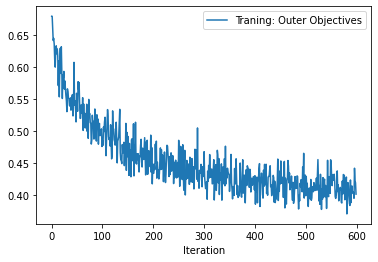

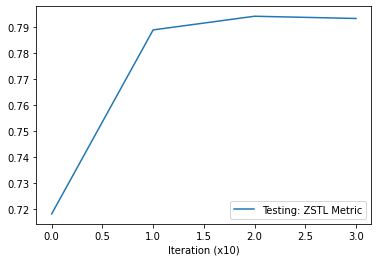

mAP at 100  tensor(0.3345, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.14698630136986296
mean metric 0.3345094569107622
rho for w_kb 0.01; mu for a_kb 0.001;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835613; align loss 0.8760124444961548
1/600 o_loss 0.6997709114849567; m train metric 0.7181000000000002; m test metric 0.7165068493150684; align loss  0.0017632842063903809
200/600 o_loss 0.43081999085843564; m train metric 0.8320000000000003; m test metric 0.7891095890410958; align loss  0.0012883543968200684
400/600 o_loss 0.4220056512206793; m train metric 0.8339; m test metric 0.7937328767123281; align loss  0.0008954107761383057
600/600 o_loss 0.3854565070569515; m train metric 0.8628000000000003; m test metric 0.7948287671232871; align loss  0.0005915611982345581
lr  0.001


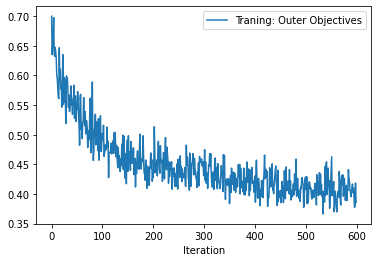

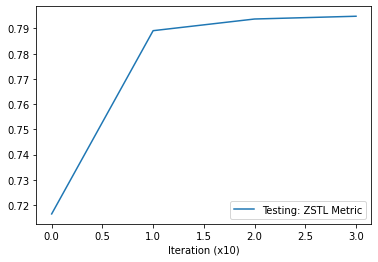

mAP at 100  tensor(0.3388, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.14698630136986313
mean metric 0.3388259208598545
rho for w_kb 0.01; mu for a_kb 0.0001;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835614; align loss 0.8760124444961548
1/600 o_loss 0.6842383758723736; m train metric 0.7296000000000002; m test metric 0.717739726027397; align loss  0.001763463020324707
200/600 o_loss 0.4412045855820179; m train metric 0.8274999999999999; m test metric 0.7892808219178086; align loss  0.0012883543968200684
400/600 o_loss 0.3865165259689093; m train metric 0.8451; m test metric 0.7929109589041099; align loss  0.0008954107761383057
600/600 o_loss 0.39480655632913114; m train metric 0.8420999999999996; m test metric 0.7925; align loss  0.0005915462970733643
lr  0.001


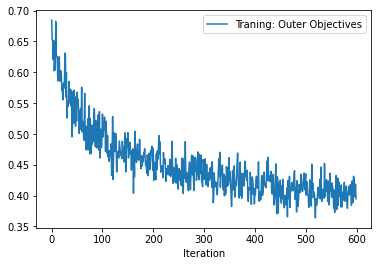

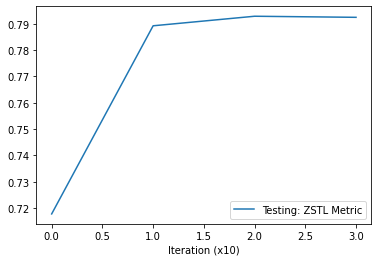

mAP at 100  tensor(0.3371, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.145513698630137
mean metric 0.3370623131180751
rho for w_kb 0.01; mu for a_kb 1e-05;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.708356164383562; align loss 0.8760124444961548
1/600 o_loss 0.686310993283987; m train metric 0.7106; m test metric 0.7177054794520545; align loss  0.001763463020324707
200/600 o_loss 0.4135920126736164; m train metric 0.8388000000000001; m test metric 0.7883219178082185; align loss  0.0012884736061096191
400/600 o_loss 0.4216577687859535; m train metric 0.8216000000000006; m test metric 0.7906849315068493; align loss  0.0008953511714935303
600/600 o_loss 0.3940181029587984; m train metric 0.8451000000000002; m test metric 0.7921232876712325; align loss  0.0005915910005569458
lr  0.001


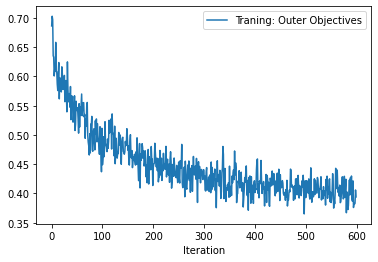

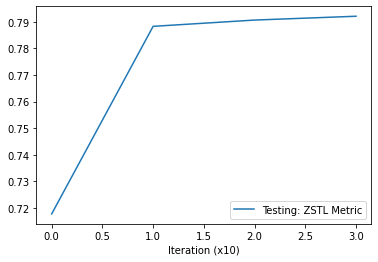

mAP at 100  tensor(0.3357, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.1456849315068493
mean metric 0.3357006898684727
rho for w_kb 0.001; mu for a_kb 0.1;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835619; align loss 0.8760124444961548
1/600 o_loss 0.6773709046840668; m train metric 0.7199999999999998; m test metric 0.717842465753425; align loss  0.0017634034156799316
200/600 o_loss 0.4335827483981848; m train metric 0.8212; m test metric 0.7874657534246569; align loss  0.0012883543968200684
400/600 o_loss 0.42381909474730495; m train metric 0.8205999999999999; m test metric 0.7929109589041096; align loss  0.000895380973815918
600/600 o_loss 0.41982299581170085; m train metric 0.8438000000000002; m test metric 0.7936301369863016; align loss  0.0005915462970733643
lr  0.001


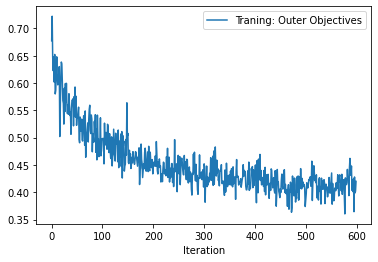

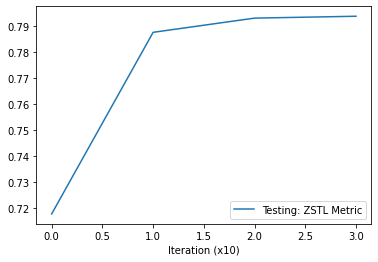

mAP at 100  tensor(0.3352, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.1468835616438357
mean metric 0.3351825128891242
rho for w_kb 0.001; mu for a_kb 0.01;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835619; align loss 0.8760124444961548
1/600 o_loss 0.6876934081315994; m train metric 0.7301999999999998; m test metric 0.7182876712328773; align loss  0.0017635226249694824
200/600 o_loss 0.44887775160372256; m train metric 0.8214999999999995; m test metric 0.7892123287671229; align loss  0.0012883543968200684
400/600 o_loss 0.4530983693152666; m train metric 0.8375; m test metric 0.7939041095890408; align loss  0.0008953511714935303
600/600 o_loss 0.4079358659684658; m train metric 0.831; m test metric 0.7937671232876712; align loss  0.000591576099395752
lr  0.001


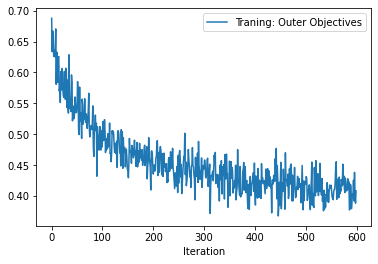

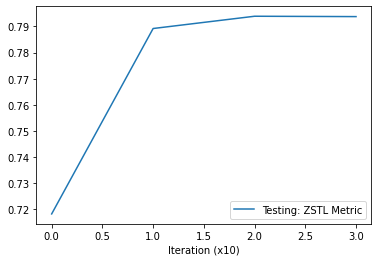

mAP at 100  tensor(0.3375, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.1467123287671233
mean metric 0.3374618751471561
rho for w_kb 0.001; mu for a_kb 0.001;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835615; align loss 0.8760124444961548
1/600 o_loss 0.7133614967763424; m train metric 0.7194999999999997; m test metric 0.7180479452054795; align loss  0.0017636418342590332
200/600 o_loss 0.44315827660262586; m train metric 0.8207999999999999; m test metric 0.7888356164383564; align loss  0.001288294792175293
400/600 o_loss 0.4395523304864764; m train metric 0.8292999999999998; m test metric 0.7927054794520555; align loss  0.0008953511714935303
600/600 o_loss 0.4176536636054516; m train metric 0.8435999999999999; m test metric 0.7940753424657531; align loss  0.0005915462970733643
lr  0.001


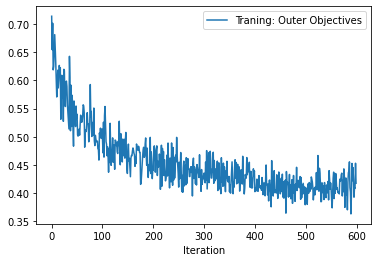

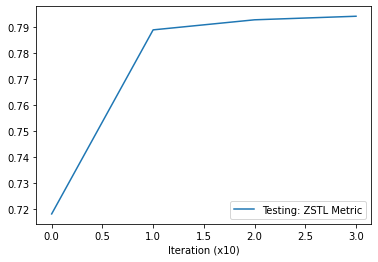

mAP at 100  tensor(0.3356, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.14667808219178088
mean metric 0.3356081296974153
rho for w_kb 0.001; mu for a_kb 0.0001;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835621; align loss 0.8760124444961548
1/600 o_loss 0.6687261287868023; m train metric 0.7188; m test metric 0.7175684931506853; align loss  0.0017634034156799316
200/600 o_loss 0.44886081539094447; m train metric 0.8200999999999997; m test metric 0.7882191780821917; align loss  0.0012884140014648438
400/600 o_loss 0.4563393668830395; m train metric 0.8228; m test metric 0.7932876712328762; align loss  0.0008954107761383057
600/600 o_loss 0.4190390621125698; m train metric 0.8409999999999997; m test metric 0.7938356164383567; align loss  0.0005915462970733643
lr  0.001


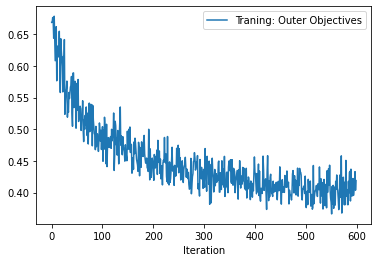

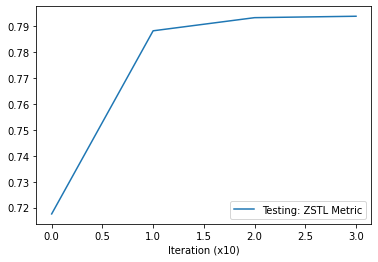

mAP at 100  tensor(0.3350, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.1464041095890411
mean metric 0.33497816708345846
rho for w_kb 0.001; mu for a_kb 1e-05;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835614; align loss 0.8760124444961548
1/600 o_loss 0.6384259049594403; m train metric 0.7512000000000001; m test metric 0.7185958904109587; align loss  0.0017635226249694824
200/600 o_loss 0.41307423733174803; m train metric 0.8345; m test metric 0.7891780821917805; align loss  0.0012883543968200684
400/600 o_loss 0.4504376794397831; m train metric 0.8322000000000002; m test metric 0.7918835616438351; align loss  0.000895380973815918
600/600 o_loss 0.40840015761554244; m train metric 0.8348999999999995; m test metric 0.7929452054794514; align loss  0.0005915611982345581
lr  0.001


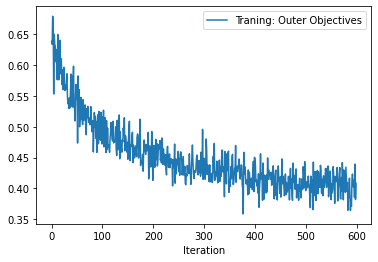

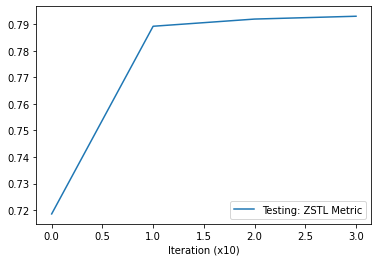

mAP at 100  tensor(0.3388, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.14712328767123292
mean metric 0.3387702232416723
rho for w_kb 0.0001; mu for a_kb 0.1;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835621; align loss 0.8760124444961548
1/600 o_loss 0.7085051108896733; m train metric 0.7326999999999998; m test metric 0.7184246575342469; align loss  0.001763761043548584
200/600 o_loss 0.45272981747984886; m train metric 0.8175; m test metric 0.7902739726027393; align loss  0.001288294792175293
400/600 o_loss 0.4469884935766459; m train metric 0.8174999999999997; m test metric 0.7922260273972603; align loss  0.0008954107761383057
600/600 o_loss 0.38086064025759697; m train metric 0.8531000000000004; m test metric 0.7934589041095891; align loss  0.0005915611982345581
lr  0.001


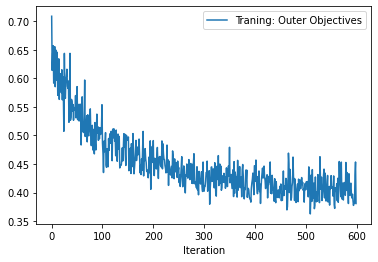

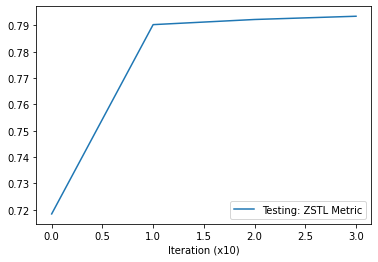

mAP at 100  tensor(0.3374, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.14773972602739716
mean metric 0.3373898295585903
rho for w_kb 0.0001; mu for a_kb 0.01;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835619; align loss 0.8760124444961548
1/600 o_loss 0.712067720592022; m train metric 0.7204999999999999; m test metric 0.7169520547945205; align loss  0.0017634034156799316
200/600 o_loss 0.4247398917376995; m train metric 0.8318999999999999; m test metric 0.7892123287671224; align loss  0.0012884140014648438
400/600 o_loss 0.4275533462315798; m train metric 0.8273; m test metric 0.7941095890410959; align loss  0.000895380973815918
600/600 o_loss 0.40072330825030805; m train metric 0.8475; m test metric 0.7955136986301371; align loss  0.0005915462970733643
lr  0.001


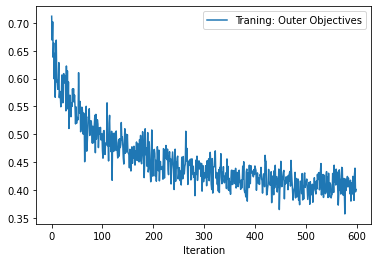

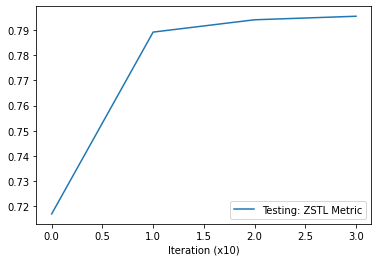

mAP at 100  tensor(0.3402, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.14770547945205478
mean metric 0.3401987729114476
New best acc 0.3401987729114476
rho for w_kb 0.0001; mu for a_kb 0.001;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835614; align loss 0.8760124444961548
1/600 o_loss 0.7085341124236584; m train metric 0.7145000000000004; m test metric 0.7184589041095883; align loss  0.0017637014389038086
200/600 o_loss 0.4513645100593567; m train metric 0.8197; m test metric 0.7878767123287671; align loss  0.0012883543968200684
400/600 o_loss 0.41112816587090495; m train metric 0.8346999999999999; m test metric 0.7935273972602744; align loss  0.000895380973815918
600/600 o_loss 0.43661925926804546; m train metric 0.8274000000000001; m test metric 0.7936643835616439; align loss  0.0005915313959121704
lr  0.001


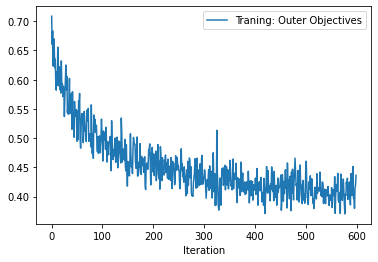

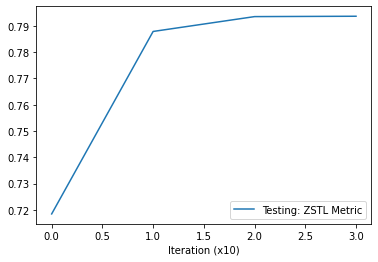

mAP at 100  tensor(0.3383, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.14705479452054798
mean metric 0.33833091463739573
rho for w_kb 0.0001; mu for a_kb 0.0001;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835615; align loss 0.8760124444961548
1/600 o_loss 0.6395711259543896; m train metric 0.7375; m test metric 0.7183219178082194; align loss  0.001763463020324707
200/600 o_loss 0.44150882348418236; m train metric 0.8228000000000002; m test metric 0.7882876712328768; align loss  0.0012884736061096191
400/600 o_loss 0.41135734632611276; m train metric 0.8289000000000005; m test metric 0.793458904109589; align loss  0.000895380973815918
600/600 o_loss 0.3840964648872614; m train metric 0.8444999999999999; m test metric 0.7932191780821916; align loss  0.0005915313959121704
lr  0.001


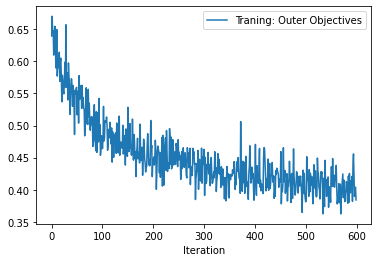

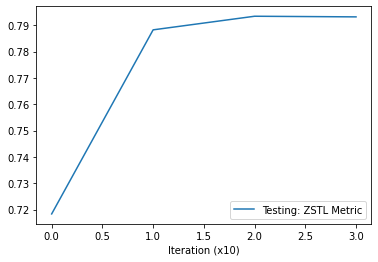

mAP at 100  tensor(0.3361, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.14719178082191783
mean metric 0.33607145827289725
rho for w_kb 0.0001; mu for a_kb 1e-05;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.708356164383562; align loss 0.8760124444961548
1/600 o_loss 0.7355252338945866; m train metric 0.7287999999999997; m test metric 0.7184589041095892; align loss  0.0017635822296142578
200/600 o_loss 0.4711139591038227; m train metric 0.8238999999999997; m test metric 0.7897260273972599; align loss  0.0012884140014648438
400/600 o_loss 0.4543406318873167; m train metric 0.8232; m test metric 0.7945205479452049; align loss  0.000895380973815918
600/600 o_loss 0.39176866739988325; m train metric 0.8601000000000005; m test metric 0.7942808219178077; align loss  0.000591576099395752
lr  0.001


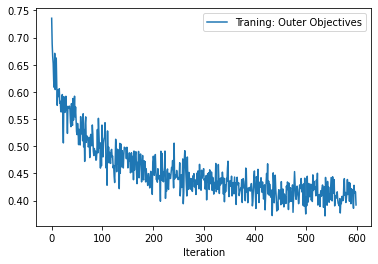

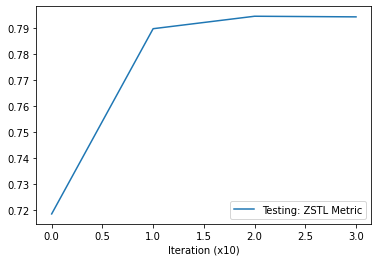

mAP at 100  tensor(0.3373, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.14633561643835624
mean metric 0.3372955934779103
rho for w_kb 1e-05; mu for a_kb 0.1;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835622; align loss 0.8760124444961548
1/600 o_loss 0.7050943103432655; m train metric 0.7254999999999997; m test metric 0.7184589041095891; align loss  0.001763463020324707
200/600 o_loss 0.45433935679495335; m train metric 0.8308; m test metric 0.7885958904109587; align loss  0.001288294792175293
400/600 o_loss 0.41038448832929136; m train metric 0.8408999999999999; m test metric 0.7927739726027395; align loss  0.000895380973815918
600/600 o_loss 0.418907323256135; m train metric 0.8358999999999998; m test metric 0.792123287671233; align loss  0.000591576099395752
lr  0.001


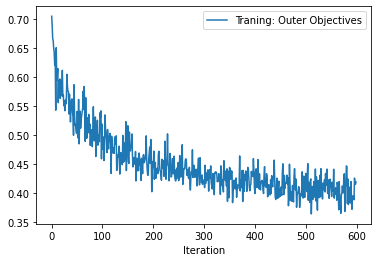

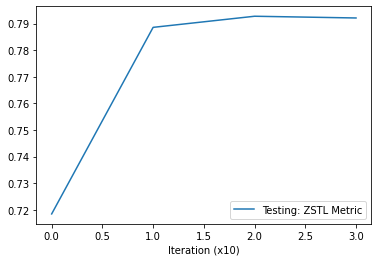

mAP at 100  tensor(0.3342, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.14647260273972598
mean metric 0.33416794091334096
rho for w_kb 1e-05; mu for a_kb 0.01;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835614; align loss 0.8760124444961548
1/600 o_loss 0.7211114186048507; m train metric 0.7081000000000002; m test metric 0.7178424657534248; align loss  0.0017634034156799316
200/600 o_loss 0.42946523807942866; m train metric 0.8316; m test metric 0.7894863013698634; align loss  0.0012883543968200684
400/600 o_loss 0.4045972166955471; m train metric 0.8437000000000002; m test metric 0.7936301369863017; align loss  0.000895380973815918
600/600 o_loss 0.3984804116934538; m train metric 0.8456999999999997; m test metric 0.7950342465753424; align loss  0.0005915313959121704
lr  0.001


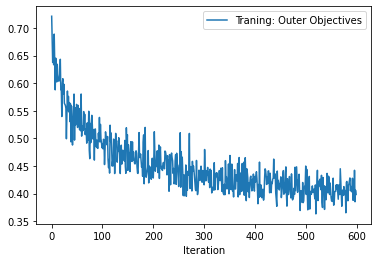

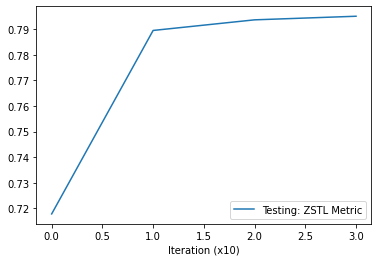

mAP at 100  tensor(0.3416, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.14660958904109586
mean metric 0.3416003292224763
New best acc 0.3416003292224763
rho for w_kb 1e-05; mu for a_kb 0.001;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835614; align loss 0.8760124444961548
1/600 o_loss 0.6740818512439728; m train metric 0.7244999999999999; m test metric 0.7177054794520548; align loss  0.0017634034156799316
200/600 o_loss 0.4640681277215481; m train metric 0.8113000000000004; m test metric 0.790445205479452; align loss  0.001288294792175293
400/600 o_loss 0.426053443774581; m train metric 0.8292999999999996; m test metric 0.7931164383561646; align loss  0.0008954107761383057
600/600 o_loss 0.41102306365966795; m train metric 0.8285999999999997; m test metric 0.7929452054794519; align loss  0.0005915611982345581
lr  0.001


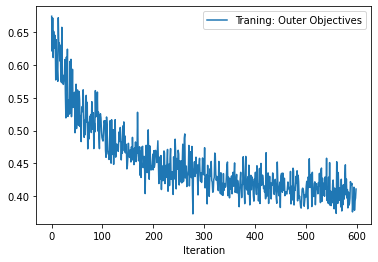

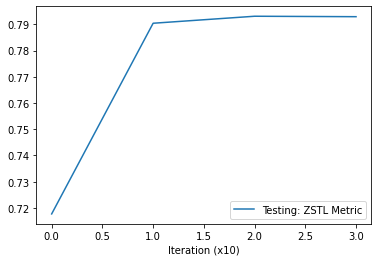

mAP at 100  tensor(0.3354, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.14753424657534248
mean metric 0.3354286881894146
rho for w_kb 1e-05; mu for a_kb 0.0001;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835612; align loss 0.8760124444961548
1/600 o_loss 0.6981135684251786; m train metric 0.7202; m test metric 0.7176369863013701; align loss  0.0017635822296142578
200/600 o_loss 0.4887934669852257; m train metric 0.8189999999999995; m test metric 0.7887671232876713; align loss  0.001288294792175293
400/600 o_loss 0.42972418874502183; m train metric 0.8339000000000002; m test metric 0.7925000000000004; align loss  0.0008954107761383057
600/600 o_loss 0.4007964838296175; m train metric 0.8398999999999998; m test metric 0.7943493150684936; align loss  0.0005915462970733643
lr  0.001


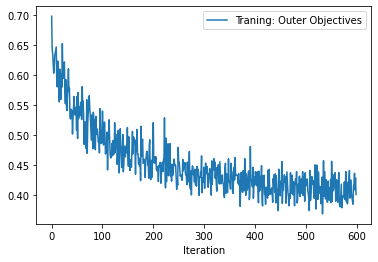

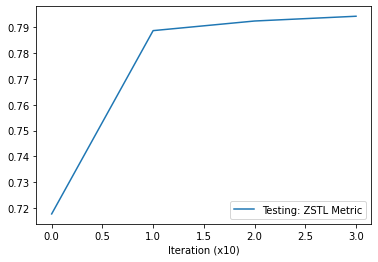

mAP at 100  tensor(0.3380, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.1463356164383562
mean metric 0.33800839867271054
rho for w_kb 1e-05; mu for a_kb 1e-05;
test  torch.Size([1892, 292]) torch.Size([292]) torch.Size([292, 100, 9750]) torch.Size([292, 100, 1])
weight_kb  torch.Size([9750, 50])
init mean test metric 0.7083561643835614; align loss 0.8760124444961548
1/600 o_loss 0.6733512769639493; m train metric 0.7332; m test metric 0.7184931506849311; align loss  0.001763463020324707
200/600 o_loss 0.4374801868200302; m train metric 0.8386999999999998; m test metric 0.7886986301369866; align loss  0.0012884140014648438
400/600 o_loss 0.4370733378082514; m train metric 0.8341000000000001; m test metric 0.7925342465753417; align loss  0.000895380973815918
600/600 o_loss 0.43479130629450086; m train metric 0.8374999999999999; m test metric 0.7935958904109589; align loss  0.0005915313959121704
lr  0.001


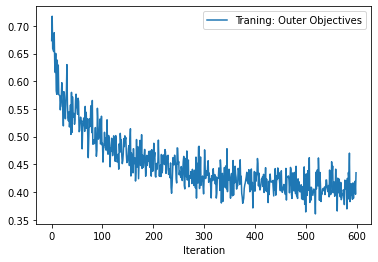

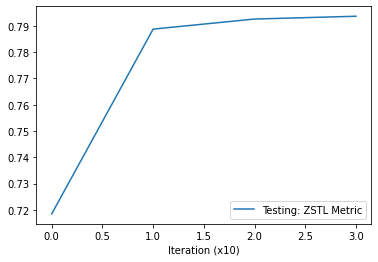

mAP at 100  tensor(0.3365, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.14681506849315062
mean metric 0.3365153120084159
best_hp  {'mu': 0.01, 'rho': 1e-05}


In [ ]:
indx = train_indx
np.random.seed(0)
val_indx = list(np.random.choice(indx, size=int(len(indx)*0.2), replace=False))
print(len(val_indx))
train_indx_splited = [x for x in indx if x not in val_indx]
print(len(train_indx_splited))

val_data_full = utils.Dataset_hetrec([(d, compressed_dataset[d]) for d in val_indx], detailed_dataset, phase='mAP', preset_x =preset_x)
val_data = utils.Dataset_hetrec([(d, compressed_dataset[d]) for d in val_indx], detailed_dataset, phase='Normal', preset_x =preset_x)
train_splited_data = utils.Dataset_hetrec([(d, compressed_dataset[d]) for d in train_indx_splited], detailed_dataset, phase='Normal', preset_x =preset_x)
val_loader = DataLoader(val_data, batch_size=int(len(val_indx)), shuffle=True)
val_loader_full = DataLoader(val_data_full, batch_size=int(len(val_indx)), shuffle=True)
train_splited_loader = DataLoader(train_splited_data, batch_size=100, shuffle=True)

best_hp = utils.hp_select_mAP(train_splited_loader, val_loader, support_loader, val_loader_full, utils.toTensor(preset_x), d, dm, net, shape_record, device, \
                              val_step = 600, activation='Softmax')
print('best_hp ', best_hp)

In [ ]:
print(best_hp)

{'mu': 0.01, 'rho': 1e-05}
